In [5]:
#install required packages
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00


In [ ]:
#test GPU device
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6141309788050005079
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14631869806847255315
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [6]:
import torch
import torch.nn as nn
# Define a custom neural network class
class ConvertModel(nn.Module):
    def __init__(self, input_dim, output_dim,N):
        super(ConvertModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.N = N

    def forward(self, x):
        N = self.N
        x = x.view(N, -1)  # Reshape the input tensor
        x = self.linear(x)
        return x

# Create an instance of the custom class
def tensor_3d_to_2d(tensor):
  N = tensor.shape[0]
  M = tensor.shape[1]
  input_dim = M * 768
  output_dim = 768
  print(N,M)
  tensor_model = ConvertModel(input_dim, output_dim, N)
  converted_tensor = tensor_model(tensor)

  return converted_tensor




In [7]:
#add bert model
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.nn.functional import softmax
import torch
#import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score, recall_score


In [8]:
def proprocess_tweets(tweets):
  processed_tweets = [preprocessTweet1(tweet) for tweet in tweets]
  return processed_tweets
#add preprocessing step to clean the tweets
import re
def preprocessTweet1(tweet):
    # process the tweets

    # Remove 'RT' from tweet
    tweet = re.sub(r'RT[\s]+', '', tweet)
    # Remove &amp; (ampersand)
    tweet = re.sub(r'&amp;', 'and', tweet)
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    #Convert @username to @USER
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    # Remove all emojis.
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    tweet = emoji_pattern.sub(r'', tweet)

    # Remove redundant spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    #remove unknown characters
    tweet = ''.join([c for c in tweet if ord(c) < 128])

    #trim
    tweet = tweet.strip('\'"')
    return tweet



In [9]:
#define the tokenize, padding, masking procedure from text to tensor

def text_to_tensor(data):
  #tokenize
  tokenized = data['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  #padding
  max_len = 0
  for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
  print("max len for padding: ",max_len, np.array(padded).shape)
  #Masking the paddding
  attention_mask = np.where(padded != 0, 1, 0)
  # print("attention mask shape:",attention_mask.shape)
  #Use pretrained Bert model to word embedding all the sentences
  input_ids = torch.tensor(padded)
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)
  # result =last_hidden_states

  return last_hidden_states[0]

In [10]:
# clean data
def clean_data(data):
  #clean tweets
  data['text'] = proprocess_tweets(data['text'])
  return(data)


In [11]:

#balance the data
def balanced_data(data):

  data_ade = data[data['label'] == 1]
  data_noade = data[data['label'] == 0]
  # print(data_ade.shape,data_noade.shape)
  #downsampling
  data_noade_downsampled = data_noade.sample(data_ade.shape[0])
  data_balanced = pd.concat([data_ade,data_noade_downsampled])
  # print(t_batch_balanced['label'].value_counts())
  #proprecess the tweets
  # print("before clean",t_batch_balanced)
  # #clean tweets
  # data_balanced['text'] = proprocess_tweets(data_balanced['text'])
  # print("after clean  ",data_balanced)
  return data_balanced



In [12]:
#import dataset
# test_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
#import dataset from github
ADETrainingdata = pd.read_csv('https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADEClassification/ADETraining.tsv', delimiter='\t')
ADEValidationdata = pd.read_csv('https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADEClassification/ADEValidation.tsv', delimiter='\t')

In [13]:
print("Training data shape:",ADETrainingdata.shape)
print("Validation data shape:",ADEValidationdata.shape)

Training data shape: (7600, 3)
Validation data shape: (400, 3)


In [14]:
#import normalization data
RawTweets = pd.read_csv('https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADENormalization/Dev/tweets.tsv',delimiter='\t')
SpansNorm = pd.read_csv('https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADENormalization/Dev/spans_norm.tsv',delimiter='\t')

#check the tweets id in Spans Norm and Raw Tweets
# print("get the tweets id in Raw Tweets:\n",RawTweets.iloc[:,0])
# print("Get the tweets id in Spans Norm:\n",SpansNorm.iloc[:,0])
list1 = RawTweets.iloc[:,0]
list2 = SpansNorm.iloc[:,0]
common_values = set(list1).intersection(set(list2))
# print("common tweets id:",common_values)
# print("Total tweets:",len(set(list1)),"Tweets with AE:",len(set(list2)),"matched tweets:",len(common_values))

In [15]:
# train the ADE model with 7600 ADETrainingData
#print(ADETrainingdata.head() , ADEValidationdata.head())
#use the first 2000 rows of the training data
# ADETrainingdata[:2000]
# ADETrainingdata.iloc[:3,-3:]
#ADETrainingdata['tweet_id'][:200]
#only use the first 300 tweets in Training data as training
# print(ADETrainingdata['label'][:300].value_counts())
# training_batch_1 =ADETrainingdata[:300]
training_batch_1 =ADETrainingdata[:800]
# training_batch_1 = balanced_data(training_batch_1)

# print(training_batch_1.head())
print("Training data shape",training_batch_1.shape)
print("Training data label distribution:\n",training_batch_1['label'].value_counts())

#testing dataset from validation dataset
#use first 100 for coding
# print(ADEValidationdata['label'][:100].value_counts())
testing_batch_1 =ADEValidationdata[:100]
print("Testing data shape",testing_batch_1.shape)
print("Testing data label distribution:\n",testing_batch_1['label'].value_counts())
# print(testing_batch_1.head())

Training data shape (800, 3)
Training data label distribution:
 0    662
1    138
Name: label, dtype: int64
Testing data shape (100, 3)
Testing data label distribution:
 0    88
1    12
Name: label, dtype: int64


In [16]:
# proprecess training data: cleaning the tweets text
#balance data
# bal_training_data = balanced_data(training_batch_1)
#clean data
# clean_training_data = clean_data(bal_training_data)
#clean the training data tweets
clean_training_data = clean_data(training_batch_1)

# print(bal_data)
print("training data shape:",training_batch_1.shape,"clean training data shape",clean_training_data.shape)

# proprecess testing data
#all clean testing data unbalanced
clean_testing_data = clean_data(testing_batch_1)
#all testing data
print("testing data shape:",testing_batch_1.shape,"clean testing data shape:",clean_testing_data.shape)
#balance testing data
# bal_testing_data = balanced_data(testing_batch_1)
#clean balanced testing data
# clean_testing_data = clean_data(bal_testing_data)

# print("testing data shape:",testing_batch_1.shape,"all clean testing data shape:",all_testing_data.shape,
#       "clean balanced testing data shape:",clean_testing_data.shape)


training data shape: (800, 3) clean training data shape (800, 3)
testing data shape: (100, 3) clean testing data shape: (100, 3)


In [17]:
#load bert model. load tokenizer and model
#Testing small bert model 'distilbert-base-uncased'
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
#testing pubmed bert model
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'ml4pubmed/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext_pub_section')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [18]:
# print(clean_training_data)
# calculate the time to do tokenization
# first step to convert the text into tensor
import time
start_time = time.time()
features_train_1 = text_to_tensor(clean_training_data)
features_test_1 = text_to_tensor(clean_testing_data)
end_time = time.time()
tokenize_time = end_time - start_time
print(f"Running time: {tokenize_time:.4f} seconds")

print("training features dimension",features_train_1.shape)
print("testing features dimension",features_test_1.shape)

max len for padding:  89 (800, 89)
max len for padding:  82 (100, 82)
Running time: 184.3475 seconds
training features dimension torch.Size([800, 89, 768])
testing features dimension torch.Size([100, 82, 768])


In [ ]:
#add NN layer to convert 3D tensor to 2D tensor
# print(fe_train_1.shape, fe_test_1.shape, fe_test_2.shape)
# fe_train_1_2d = tensor_3d_to_2d(fe_train_1).detach().numpy()
# fe_test_1_2d = tensor_3d_to_2d(fe_test_1).detach().numpy()
# fe_test_2_2d = tensor_3d_to_2d(fe_test_2).detach().numpy()
# print(fe_train_1_2d.shape, fe_test_1_2d.shape, fe_test_2_2d.shape)


In [19]:
# print(features_train_1.shape)
features_train_1_2d = features_train_1[:,0,:].numpy()
features_test_1_2d = features_test_1[:,0,:].numpy()
labels_train_1_2d = clean_training_data['label']
labels_test_1_2d = clean_testing_data['label']
print("dimension for features in training:",features_train_1_2d.shape,"dimension for features in testing:",features_test_1_2d.shape)
print("lables in training:",labels_train_1_2d.shape, "labels in testing:",labels_test_1_2d.shape)
# print(labels_test_1_2d)

dimension for features in training: (800, 768) dimension for features in testing: (100, 768)
lables in training: (800,) labels in testing: (100,)


In [ ]:
# ex_X_test, ex_y_test = features_test_1_2d[:100], labels_test_1_2d[:100]
# print(ex_X_test.shape,ex_y_test.shape)

(100, 768) (100,)


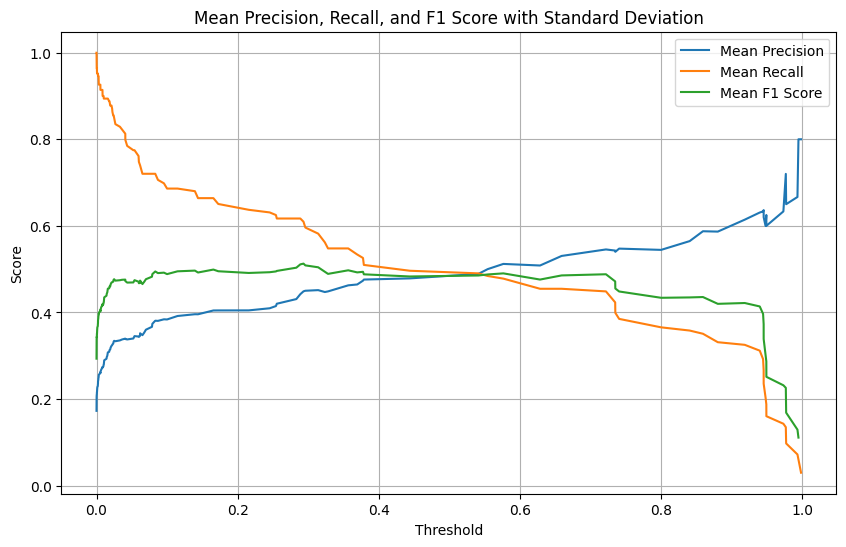

Average Precision: [0.1725     0.17358491 0.17468354 0.17579618 0.17692308 0.17806452
 0.17922078 0.18039216 0.18157895 0.18278146 0.184      0.1852349
 0.18648649 0.1877551  0.1890411  0.19034483 0.19027778 0.19160839
 0.19295775 0.19432624 0.19428571 0.19568345 0.19710145 0.19854015
 0.2        0.20148148 0.20298507 0.20451128 0.20606061 0.20610687
 0.20769231 0.20930233 0.209375   0.21102362 0.21269841 0.2144
 0.21451613 0.21626016 0.21639344 0.21818182 0.22       0.22184874
 0.22372881 0.22564103 0.22758621 0.22956522 0.23157895 0.23362832
 0.23392857 0.23603604 0.23818182 0.24036697 0.24259259 0.24485981
 0.24716981 0.24952381 0.25192308 0.25242718 0.25294118 0.25544554
 0.256      0.25858586 0.26122449 0.25979381 0.2625     0.26526316
 0.26808511 0.27096774 0.27391304 0.27252747 0.27555556 0.27865169
 0.27954545 0.28275862 0.28604651 0.28941176 0.29285714 0.29638554
 0.3        0.3037037  0.3075     0.30886076 0.31282051 0.31428571
 0.31842105 0.32266667 0.32432432 0.3260274  0.3

In [30]:
# add 5 fold cross validation and repeat 100 times
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt



num_repeats = 1
num_folds = 5
#repeat 100 times for 5 fold cross validation
rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=42)

# Initialize the under-sampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)



precision_scores = []
recall_scores = []
f1_scores = []

ex_precision_scores = []
ex_recall_scores = []
ex_f1_scores = []

# ex_X_test, ex_y_test = features_test_1_2d, labels_test_1_2d
ex_X_test, ex_y_test = features_test_1_2d[:100], labels_test_1_2d[:100]
# print(ex_X_test.shape,ex_y_test.shape)

# print(features_train_1_2d[0],labels_train_1_2d[0])
for train_index, test_index in rkf.split(features_train_1_2d):
    # print(train_index.shape,test_index.shape)
    X_train, X_test = features_train_1_2d[train_index], features_train_1_2d[test_index]
    y_train, y_test = labels_train_1_2d[train_index], labels_train_1_2d[test_index]
    # print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

    # print(y_train.value_counts())
    #balance the 4 fold training data
    # X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train, y_train
    # print(X_train_resampled.shape,y_train_resampled)

    #define the parameter grid to search
    param_grid = {
    'C': np.linspace(0.0001, 100, 10)
    }

    # Create and train a logistic regression model
    model = LogisticRegression()
    scorer = make_scorer(accuracy_score)
    grid_search = GridSearchCV(model, param_grid, scoring=scorer)
    # Fit the grid search on the data
    grid_search.fit(X_train_resampled, y_train_resampled)
    # print(f'Best Parameters: {grid_search.best_params_}')
    # print(f'Best Accuracy: {grid_search.best_score_:.2f}')

    #use the best parameter for the model
    lr_clf = LogisticRegression(C=grid_search.best_params_['C'])
    lr_clf.fit(X_train_resampled, y_train_resampled)
    # model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on 1 fold  test
    y_pred = lr_clf.predict(X_test)
    # get predict probility for positive class
    y_pred_prob = lr_clf.predict_proba(X_test)[:, 1]


    # make prediction on external test
    ex_y_pred = lr_clf.predict(ex_X_test)

    # calcuate matrics for 1 fold test
    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Calculate precision, recall, and F1-score
    # precision, recall, thresholds = precision_recall_curve(y, y_prob)
    # precision = precision_score(y_test, y_pred)
    # recall = recall_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)

    # calcuate matrics for external test
    ex_precision = precision_score(ex_y_test, ex_y_pred)
    ex_recall = recall_score(ex_y_test, ex_y_pred)
    ex_f1 = f1_score(ex_y_test, ex_y_pred)

    # precision_list.append(precision[:-1])
    # recall_list.append(recall[:-1])
    # f1_list.append(f1[:-1])
    # add scores for 1 fold test
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    #


    # add scores for 1 fold test
    ex_precision_scores.append(ex_precision)
    ex_recall_scores.append(ex_recall)
    ex_f1_scores.append(ex_f1)


#calculate matrics for 1 fold test
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Convert lists to arrays for easier manipulation
all_precision = np.array(precision_scores)
all_recall = np.array(recall_scores)
all_f1_scores = np.array(f1_scores)

# Calculate mean and standard deviation
mean_precision = np.mean(all_precision, axis=0)
mean_recall = np.mean(all_recall, axis=0)
mean_f1_scores = np.mean(all_f1_scores, axis=0)

std_precision = np.std(all_precision, axis=0)
std_recall = np.std(all_recall, axis=0)
std_f1_scores = np.std(all_f1_scores, axis=0)

# Plot mean and standard deviation
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_precision[:-1], label='Mean Precision')
# plt.fill_between(thresholds, mean_precision - std_precision, mean_precision + std_precision, alpha=0.2)

plt.plot(thresholds, mean_recall[:-1], label='Mean Recall')
# plt.fill_between(thresholds, mean_recall - std_recall, mean_recall + std_recall, alpha=0.2)

plt.plot(thresholds, mean_f1_scores[:-1], label='Mean F1 Score')
# plt.fill_between(thresholds, mean_f1_scores - std_f1_scores, mean_f1_scores + std_f1_scores, alpha=0.2)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Mean Precision, Recall, and F1 Score with Standard Deviation')
plt.legend()
plt.grid()
plt.show()

print(f"Average Precision: {mean_precision} ± {std_precision}")
# print(f"Average Recall: {mean_recall[:-1]:.4f} ± {std_recall[:-1]:.4f}")
# print(f"Average F1-Score: {mean_f1[:-1]:.4f} ± {std_f1[:-1]:.4f}")




In [24]:
# add 5 fold cross validation and repeat 100 times
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, accuracy_score


num_repeats = 1
num_folds = 5
#repeat 100 times for 5 fold cross validation
rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=42)

# Initialize the under-sampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)



precision_scores = []
recall_scores = []
f1_scores = []

ex_X_test, ex_y_test = features_test_1_2d, labels_test_1_2d

# print(features_train_1_2d[0],labels_train_1_2d[0])
for train_index, test_index in rkf.split(features_train_1_2d):
    # print(train_index.shape,test_index.shape)
    X_train, X_test = features_train_1_2d[train_index], features_train_1_2d[test_index]
    y_train, y_test = labels_train_1_2d[train_index], labels_train_1_2d[test_index]
    # print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

    # print(y_train.value_counts())
    #balance the 4 fold training data
    # X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train, y_train
    # print(X_train_resampled.shape,y_train_resampled)
    y_prob = cross_val_predict(model, X_train_resampled, y_train_resampled, cv=5, method='predict_proba')[:, 1]

    #define the parameter grid to search
    param_grid = {
    'C': np.linspace(0.0001, 100, 10)
    }

    # Create and train a logistic regression model
    model = LogisticRegression()
    scorer = make_scorer(accuracy_score)
    grid_search = GridSearchCV(model, param_grid, scoring=scorer)
    # Fit the grid search on the data
    grid_search.fit(X_train_resampled, y_train_resampled)
    # print(f'Best Parameters: {grid_search.best_params_}')
    # print(f'Best Accuracy: {grid_search.best_score_:.2f}')

    #use the best parameter for the model
    lr_clf = LogisticRegression(C=grid_search.best_params_['C'])
    lr_clf.fit(X_train_resampled, y_train_resampled)
    # model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    # y_pred = lr_clf.predict(X_test)
    ex_y_pred = lr_clf.predict(ex_X_test)
    # Calculate precision, recall, and F1-score
    # precision = precision_score(y_test, y_pred)
    # recall = recall_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)
    precision = precision_score(ex_y_test, ex_y_pred)
    recall = recall_score(ex_y_test, ex_y_pred)
    f1 = f1_score(ex_y_test, ex_y_pred)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

average_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
average_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
average_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
# precision_mean = np.mean(precision_scores)
# precision_std = np.std(precision_scores)
# recall_mean = np.mean(recall_scores)
# recall_std = np.std(recall_scores)
# f1_mean = np.mean(f1_scores)
# f1_std = np.std(f1_scores)

print(f"Average Precision: {average_precision:.4f} ± {std_precision:.4f}")
print(f"Average Recall: {average_recall:.4f} ± {std_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f} ± {std_f1:.4f}")
print("precision_scores:",precision_scores)
print("recall_scores:",recall_scores)
print("f1_scores:",f1_scores)




Average Precision: 0.3218 ± 0.1627
Average Recall: 0.4167 ± 0.2173
Average F1-Score: 0.3623 ± 0.1847
precision_scores: [0.42857142857142855, 0.4117647058823529, 0.4117647058823529, 0.0, 0.35714285714285715]
recall_scores: [0.5, 0.5833333333333334, 0.5833333333333334, 0.0, 0.4166666666666667]
f1_scores: [0.4615384615384615, 0.4827586206896552, 0.4827586206896552, 0.0, 0.3846153846153846]


training feature dimension (1600, 768)
testing feature dimension (400, 768)
training label dimension (1600,)
training label dimension (400,)
best parameters:  {'C': 11.1112}
best scrores:  0.8556250000000001
precision 0.6323529411764706 recall: 0.5443037974683544 f1: 0.5850340136054422
Accuracy: 0.8475
MCC: 0.49433544989517164
True Negatives: 296
False Positives: 25
False Negatives: 36
True Positives: 43


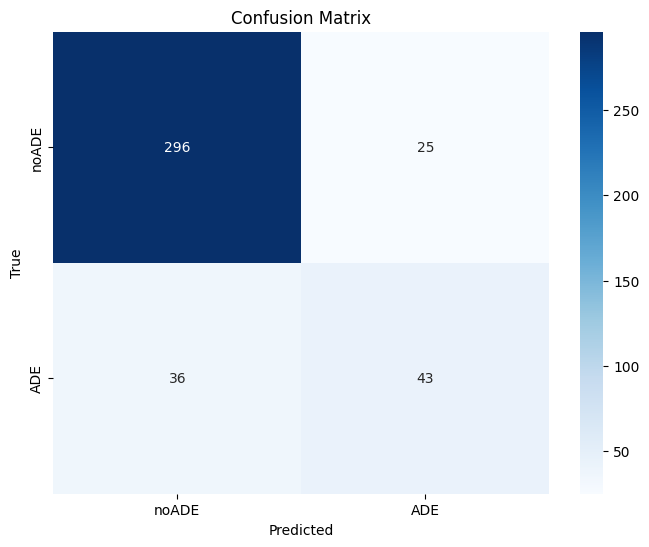

In [ ]:
#split the features and labels in training
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

ex_X_test, ex_y_test = features_test_1_2d, labels_test_1_2d


train_features, test_features, train_labels, test_labels = train_test_split(features_train_1_2d, labels_train_1_2d, test_size = 0.2, random_state = 42)
print("training feature dimension",train_features.shape)
print("testing feature dimension",test_features.shape)
print("training label dimension",train_labels.shape)
print("training label dimension",test_labels.shape)

#refine parameters for logisticRegression model
parameters = {'C': np.linspace(0.0001, 100, 10)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

lr_clf = LogisticRegression(C=grid_search.best_params_['C'])
lr_clf.fit(train_features, train_labels)

lr_clf.score(test_features, test_labels)


lr_clf.score(train_features, train_labels)


predict_test_labels = lr_clf.predict(test_features)

precision_1 = precision_score(test_labels, predict_test_labels)

recall_1 = recall_score(test_labels, predict_test_labels)

f1_1 = f1_score(test_labels, predict_test_labels)
print("precision",precision_1, "recall:",recall_1, "f1:",f1_1)
accuracy_1 = accuracy_score(test_labels, predict_test_labels)
print("Accuracy:", accuracy_1)

# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(test_labels, predict_test_labels)
print("MCC:", mcc)

## Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, predict_test_labels)

# Extract TP, TN, FP, FN from the confusion matrix
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positives:", TP)

class_labels = ['noADE', 'ADE']
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

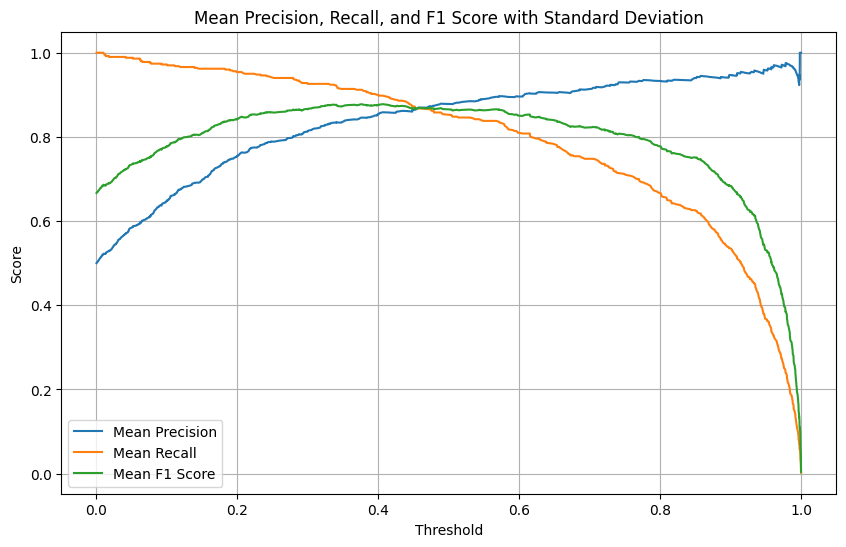

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score

# Create a toy dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Lists to store results
all_precision = []
all_recall = []
all_f1_scores = []

# Repeat the process 100 times
for _ in range(100):
    # Get predicted probabilities using 5-fold cross-validation
    y_prob = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y, y_prob)

    # Calculate F1 score based on precision and recall
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Append results to lists
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1_scores.append(f1_scores)

# Convert lists to arrays for easier manipulation
all_precision = np.array(all_precision)
all_recall = np.array(all_recall)
all_f1_scores = np.array(all_f1_scores)

# Calculate mean and standard deviation
mean_precision = np.mean(all_precision, axis=0)
mean_recall = np.mean(all_recall, axis=0)
mean_f1_scores = np.mean(all_f1_scores, axis=0)

std_precision = np.std(all_precision, axis=0)
std_recall = np.std(all_recall, axis=0)
std_f1_scores = np.std(all_f1_scores, axis=0)

# Plot mean and standard deviation
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_precision[:-1], label='Mean Precision')
# plt.fill_between(thresholds, mean_precision - std_precision, mean_precision + std_precision, alpha=0.2)

plt.plot(thresholds, mean_recall[:-1], label='Mean Recall')
# plt.fill_between(thresholds, mean_recall - std_recall, mean_recall + std_recall, alpha=0.2)

plt.plot(thresholds, mean_f1_scores[:-1], label='Mean F1 Score')
# plt.fill_between(thresholds, mean_f1_scores - std_f1_scores, mean_f1_scores + std_f1_scores, alpha=0.2)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Mean Precision, Recall, and F1 Score with Standard Deviation')
plt.legend()
plt.grid()
plt.show()
